# Import Library

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

# Import Data

In [ ]:
ZIP_FILE_NAME = "Teh_Reconstructed.zip"
EXTRACT_TO_FOLDER = "Teh_Reconstructed_Data_FE"
TEA_TYPES = ["BOHEA", "BOP", "PF"]
LABEL_MAP = {tea: i for i, tea in enumerate(TEA_TYPES)}
CV_FOLDS = 3

# Feature Engineering

In [ ]:
def extract_features_from_series(series_data_np):
    features = []
    s_std = np.std(series_data_np)

    features.append(np.mean(series_data_np))
    features.append(s_std)
    features.append(np.median(series_data_np))
    features.append(np.min(series_data_np))
    features.append(np.max(series_data_np))
    features.append(np.max(series_data_np) - np.min(series_data_np))
    features.append(np.percentile(series_data_np, 25))
    features.append(np.percentile(series_data_np, 75))
    features.append(np.percentile(series_data_np, 75) - np.percentile(series_data_np, 25)) # IQR

    # Handle cases with zero or near-zero standard deviation for skew and kurtosis
    if s_std < 1e-9:
        features.append(0.0)  # Skewness for constant data
        features.append(0.0)  # Fisher Kurtosis for constant data (normal is 0, so flat is also 0)
    else:
        features.append(skew(series_data_np))
        features.append(kurtosis(series_data_np)) # scipy.stats.kurtosis is Fisher's (normal = 0)
    return features

In [ ]:
def extract_features_from_file_df(df):
    all_sensor_features = []
    if df.empty: # Handle empty dataframe case
        print("Warning: Encountered an empty DataFrame during feature extraction.")
        return np.full(11 * 6, np.nan)

    for col in df.columns:
        sensor_series = df[col].values
        if np.all(np.isnan(sensor_series)):
            print(f"Warning: Sensor column {col} contains all NaNs. Appending NaNs for its features.")
            all_sensor_features.extend([np.nan] * 11)
        else:
            all_sensor_features.extend(extract_features_from_series(sensor_series))
    return np.array(all_sensor_features)

In [ ]:
class TeaFeatureDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
        self.num_original_features = 0
        self.num_engineered_features_per_sensor = 11

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print(f"Warning: Loaded empty CSV: {file_path}")
                 # Create a dummy feature vector of NaNs if df is empty
                engineered_features = np.full(self.num_engineered_features_per_sensor * 6, np.nan) # 6 original features
            else:
                if idx == 0 and self.num_original_features == 0:
                    self.num_original_features = df.shape[1]
                engineered_features = extract_features_from_file_df(df)
        except pd.errors.EmptyDataError:
            print(f"Warning: CSV file {file_path} is empty or unreadable.")
            # Create a dummy feature vector of NaNs
            num_expected_original_features = 6 # Fallback if num_original_features not set
            engineered_features = np.full(self.num_engineered_features_per_sensor * num_expected_original_features, np.nan)


        return torch.FloatTensor(engineered_features), torch.LongTensor([label]).squeeze()

    def get_feature_names(self):
        if not self.file_paths: return []

        try:
            sensor_cols = pd.read_csv(self.file_paths[0]).columns
            self.num_original_features = len(sensor_cols)
        except Exception:
            # Fallback if first file is problematic, assume standard names or count
            print("Warning: Could not read first file for sensor names. Using generic names.")
            sensor_cols = [f"Sensor_{i+1}" for i in range(6)]
            self.num_original_features = 6


        feature_names_raw = ["mean", "std", "median", "min", "max", "range", "p25", "p75", "iqr", "skew", "kurtosis"]

        full_feature_names = []
        for sensor_name in sensor_cols:
            for feat_name in feature_names_raw:
                full_feature_names.append(f"{sensor_name.replace(' ', '_')}_{feat_name}")
        return full_feature_names

In [ ]:
def get_file_paths_and_labels(data_root_folder, subset_folder_name):
    file_paths = []
    labels = []
    subset_path = os.path.join(data_root_folder, subset_folder_name)

    for tea_type in TEA_TYPES:
        tea_folder_path = os.path.join(subset_path, tea_type)
        if not os.path.exists(tea_folder_path):
            print(f"Warning: Folder not found {tea_folder_path}")
            continue
        for filename in sorted(os.listdir(tea_folder_path)):
            if filename.endswith(".csv"):
                file_paths.append(os.path.join(tea_folder_path, filename))
                labels.append(LABEL_MAP[tea_type])
    return file_paths, labels

# Run The Code

Extracting Teh_Reconstructed.zip to Teh_Reconstructed_Data_FE...
Extraction complete.
Found 24 training files, 6 validation files, 15 test files.
Number of engineered features: 66
Shape of engineered training features: (24, 66)
NaNs in X_train_fe BEFORE imputation: 0
NaNs in X_train_fe AFTER imputation: 0

--- Training and Evaluating Classifiers (with GridSearchCV) ---

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1}
Best CV accuracy for Logistic Regression: 1.0000
Validation Accuracy for tuned Logistic Regression: 1.0000

Training SVC...
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV accuracy for SVC: 1.0000
Validation Accuracy for tuned SVC: 1.0000

Training Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy for Random Forest: 1.0000
Validation Accuracy for tuned Random Forest: 1.0000

--- Final Evaluation on Test Set ---

--- Logis

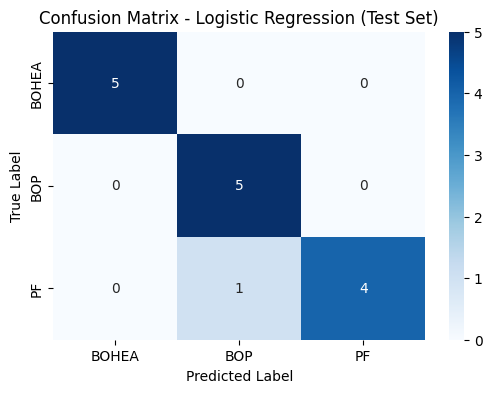


--- SVC Test Set Performance ---
Test Accuracy: 0.8667

Classification Report (Test Set):
              precision    recall  f1-score   support

       BOHEA       1.00      1.00      1.00         5
         BOP       0.71      1.00      0.83         5
          PF       1.00      0.60      0.75         5

    accuracy                           0.87        15
   macro avg       0.90      0.87      0.86        15
weighted avg       0.90      0.87      0.86        15


Confusion Matrix (Test Set):


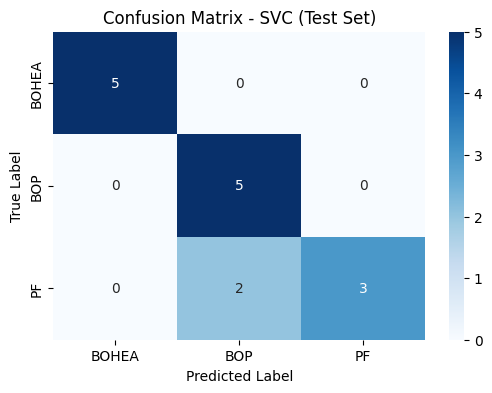


--- Random Forest Test Set Performance ---
Test Accuracy: 1.0000

Classification Report (Test Set):
              precision    recall  f1-score   support

       BOHEA       1.00      1.00      1.00         5
         BOP       1.00      1.00      1.00         5
          PF       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix (Test Set):


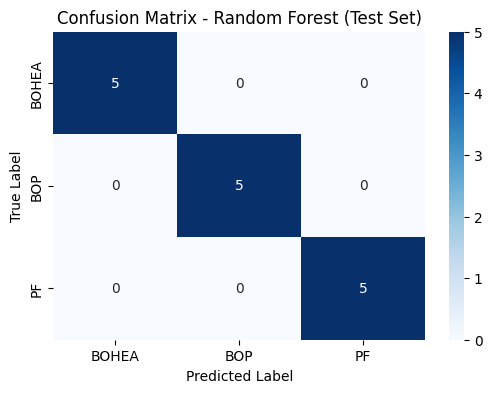


Cleaning up extracted data: Teh_Reconstructed_Data_FE


In [ ]:
def main():
    if os.path.exists(EXTRACT_TO_FOLDER):
        print(f"Removing existing extracted folder: {EXTRACT_TO_FOLDER}")
        shutil.rmtree(EXTRACT_TO_FOLDER)

    if not os.path.exists(ZIP_FILE_NAME):
        print(f"Error: {ZIP_FILE_NAME} not found. Please place it in the script's directory.")
        return

    print(f"Extracting {ZIP_FILE_NAME} to {EXTRACT_TO_FOLDER}...")
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO_FOLDER)
    print("Extraction complete.")

    data_root = EXTRACT_TO_FOLDER

    train_files, train_labels_list = get_file_paths_and_labels(data_root, "Train")
    val_files, val_labels_list = get_file_paths_and_labels(data_root, "Validation")
    test_files, test_labels_list = get_file_paths_and_labels(data_root, "Test")

    if not train_files:
        print("No training files found. Check zip structure and paths.")
        return

    print(f"Found {len(train_files)} training files, {len(val_files)} validation files, {len(test_files)} test files.")

    train_feature_dataset = TeaFeatureDataset(train_files, train_labels_list)
    feature_names = train_feature_dataset.get_feature_names()
    print(f"Number of engineered features: {len(feature_names)}")


    X_train_fe_list = []
    for i in range(len(train_feature_dataset)):
        features, _ = train_feature_dataset[i]
        X_train_fe_list.append(features.numpy())
    X_train_fe = np.array(X_train_fe_list)
    y_train = np.array([train_feature_dataset[i][1].numpy() for i in range(len(train_feature_dataset))])

    val_feature_dataset = TeaFeatureDataset(val_files, val_labels_list)
    X_val_fe_list = []
    for i in range(len(val_feature_dataset)):
        features, _ = val_feature_dataset[i]
        X_val_fe_list.append(features.numpy())
    X_val_fe = np.array(X_val_fe_list)
    y_val = np.array([val_feature_dataset[i][1].numpy() for i in range(len(val_feature_dataset))])

    test_feature_dataset = TeaFeatureDataset(test_files, test_labels_list)
    X_test_fe_list = []
    for i in range(len(test_feature_dataset)):
        features, _ = test_feature_dataset[i]
        X_test_fe_list.append(features.numpy())
    X_test_fe = np.array(X_test_fe_list)
    y_test = np.array([test_feature_dataset[i][1].numpy() for i in range(len(test_feature_dataset))])

    print(f"Shape of engineered training features: {X_train_fe.shape}")

    # --- Handle NaNs from feature extraction before scaling ---
    print(f"NaNs in X_train_fe BEFORE imputation: {np.isnan(X_train_fe).sum()}")
    X_train_fe = np.nan_to_num(X_train_fe, nan=0.0, posinf=0.0, neginf=0.0)
    X_val_fe = np.nan_to_num(X_val_fe, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_fe = np.nan_to_num(X_test_fe, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"NaNs in X_train_fe AFTER imputation: {np.isnan(X_train_fe).sum()}")


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fe)
    X_val_scaled = scaler.transform(X_val_fe)
    X_test_scaled = scaler.transform(X_test_fe)

    # Additional check for NaNs after scaling (e.g., if a feature had 0 std dev in training)
    if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
        print("Warning: NaNs or Infs found in X_train_scaled. Imputing with 0.")
        X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    if np.isnan(X_val_scaled).any() or np.isinf(X_val_scaled).any():
        print("Warning: NaNs or Infs found in X_val_scaled. Imputing with 0.")
        X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    if np.isnan(X_test_scaled).any() or np.isinf(X_test_scaled).any():
        print("Warning: NaNs or Infs found in X_test_scaled. Imputing with 0.")
        X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced', random_state=42),
        "SVC": SVC(probability=True, class_weight='balanced', random_state=42),
        "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
    }

    param_grids = {
        "Logistic Regression": {'C': [0.01, 0.1, 1, 10, 100]},
        "SVC": {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']},
        "Random Forest": {'n_estimators': [50, 100], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
    }

    best_estimators = {}

    min_class_count_train = np.min(np.unique(y_train, return_counts=True)[1]) if len(y_train) > 0 else 0
    actual_cv_folds = min(CV_FOLDS, min_class_count_train)

    if actual_cv_folds < 2 and len(y_train) > 0 :
        print(f"Warning: min_class_count_train ({min_class_count_train}) or total samples is too small for {CV_FOLDS}-fold CV. Setting to direct fit.")
        stratified_kfold_cv = None
    elif len(y_train) == 0:
        print("Error: No training labels available. Cannot proceed with training.")
        return
    else:
        stratified_kfold_cv = StratifiedKFold(n_splits=actual_cv_folds, shuffle=True, random_state=42)

    print("\n--- Training and Evaluating Classifiers (with GridSearchCV) ---")
    for name, clf_template in classifiers.items():
        print(f"\nTraining {name}...")
        if stratified_kfold_cv:
            grid_search = GridSearchCV(clf_template, param_grids[name], cv=stratified_kfold_cv, scoring='accuracy', n_jobs=-1, error_score='raise')
            try:
                grid_search.fit(X_train_scaled, y_train)
                best_estimators[name] = grid_search.best_estimator_
                print(f"Best parameters for {name}: {grid_search.best_params_}")
                print(f"Best CV accuracy for {name}: {grid_search.best_score_:.4f}")

                if len(X_val_scaled) > 0:
                    val_preds = best_estimators[name].predict(X_val_scaled)
                    val_acc = accuracy_score(y_val, val_preds)
                    print(f"Validation Accuracy for tuned {name}: {val_acc:.4f}")
                else:
                    print("No validation data to evaluate tuned model.")

            except ValueError as e:
                print(f"ValueError during GridSearchCV for {name}: {e}")
                print("This might be due to NaNs or Infs in the data. Check previous imputation steps.")
                best_estimators[name] = None
        else:
            print(f"Fitting {name} directly (no CV).")
            try:
                clf_instance = clf_template
                clf_instance.fit(X_train_scaled, y_train)
                best_estimators[name] = clf_instance
                if len(X_val_scaled) > 0:
                    val_preds = best_estimators[name].predict(X_val_scaled)
                    val_acc = accuracy_score(y_val, val_preds)
                    print(f"Validation Accuracy for {name} (direct fit): {val_acc:.4f}")
                else:
                    print("No validation data to evaluate model.")
            except ValueError as e:
                print(f"ValueError during direct fit for {name}: {e}")
                best_estimators[name] = None


    print("\n--- Final Evaluation on Test Set ---")
    if not X_test_scaled.size > 0:
        print("No test data to evaluate.")
    else:
        for name, estimator in best_estimators.items():
            if estimator is None:
                print(f"Skipping {name} due to previous training error.")
                continue
            print(f"\n--- {name} Test Set Performance ---")
            try:
                test_preds = estimator.predict(X_test_scaled)
                test_acc = accuracy_score(y_test, test_preds)
                print(f"Test Accuracy: {test_acc:.4f}")

                print("\nClassification Report (Test Set):")
                print(classification_report(y_test, test_preds, target_names=TEA_TYPES, zero_division=0))

                print("\nConfusion Matrix (Test Set):")
                cm = confusion_matrix(y_test, test_preds, labels=list(LABEL_MAP.values()))
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=TEA_TYPES, yticklabels=TEA_TYPES)
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.title(f'Confusion Matrix - {name} (Test Set)')
                plt.show()
            except Exception as e:
                 print(f"Error during testing for {name}: {e}")


    if os.path.exists(EXTRACT_TO_FOLDER):
        print(f"\nCleaning up extracted data: {EXTRACT_TO_FOLDER}")
        shutil.rmtree(EXTRACT_TO_FOLDER)

if __name__ == "__main__":
    main()